In [164]:
import torch 
import pandas as pd 
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as DataLoader2
from sklearn.metrics import r2_score 
from matplotlib import pyplot as plt 
import pickle as pkl 
import seaborn as sbn 
import pandas as pd 
import pickle as pkl
import copy 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, ndcg_score

import sys
sys.path.append('../')
from src.data.PrismDataset import PrismDataset
from src.proc import utils
from src.models.utils import predict_gsnn
from src.models.NN import NN
from src.models.Logistic import Logistic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Drug Priortization 

$$ (D, C) \rightarrow GSNN \rightarrow x_{expr} \rightarrow VIAB \rightarrow p(y_{viab}) $$

In [165]:
data = torch.load('../output/exp1/FOLD-1/GSNN/1e808caf-2cb9-46b3-830d-c3f106f5ef6f/Data.pt')
gsnn = torch.load('../output/exp1/FOLD-1/GSNN/1e808caf-2cb9-46b3-830d-c3f106f5ef6f/model-40.pt')
proc = '../output/exp1/proc/'
viab_ensemble = torch.load('../output/exp1/FOLD-1/GSNN/1e808caf-2cb9-46b3-830d-c3f106f5ef6f/ViabNNEnsemble.pt')

In [166]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [176]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')[lambda x: x.cell_iname.isin(data.cellspace)]
cellinfo.head()

,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
93,22RV1,CVCL_1045,NaN,NaN,NaN,60,RPMI-164 ATCC catalog # 3-21,NaN,c-63,tumor,Unknown,M,Unknown,prostate,prostate cancer,carcinoma,NaN,adherent,22RV1_PROSTATE,22Rv-1|22Rv1
94,HEC1A,CVCL_0293,71,NaN,NaN,48,McCoys5A (Hyclone Cat.# SH32.1),NaN,c-10,tumor,Unknown,F,Unknown,endometrium,endometrial cancer,adenocarcinoma,NaN,adherent,HEC1A_ENDOMETRIUM,HEC-1-A
104,HL60,CVCL_0002,36,NaN,NaN,25,IMDM ATCC catalog #3-25,CCL-240,NaN,tumor,Unknown,F,Unknown,haematopoietic_and_lymphoid_tissue,leukemia,acute myelogenous leukemia (aml),ATCC,suspension,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HL-60|HL 60
105,K562,CVCL_0004,53,NaN,NaN,18-24,IMDM ATCC catalog #3-25,CCL-243,NaN,tumor,Unknown,F,Metastatic,haematopoietic_and_lymphoid_tissue,leukemia,chronic myelogenous leukemia (cml),ATCC,suspension,K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,K-562|GM05372
107,THP1,CVCL_0006,1,NaN,NaN,19-50,RPMI-164 ATCC catalog # 3-21,TIB-202,NaN,tumor,Unknown,M,Unknown,haematopoietic_and_lymphoid_tissue,leukemia,acute myelogenous leukemia (aml),ATCC,suspension,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,THP-1|THP 1


In [5]:
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[lambda x: x.pert_id.isin([x.split('__')[1] for x in data.node_names if x.split('__')[0] == 'DRUG'])]
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
410,BRD-K42805893,AZD-9291,NaN,NaN,COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc1nccc(n1)-...,DUYJMQONPNNFPI-UHFFFAOYSA-N,osimertinib
508,BRD-K62391742,GDC-0199,NaN,NaN,CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3cc...,LQBVNQSMGBZMKD-UHFFFAOYSA-N,venetoclax
605,BRD-K43002773,GDC-0068,AKT3,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib
606,BRD-K43002773,GDC-0068,AKT1,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib
607,BRD-K43002773,GDC-0068,AKT2,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib


In [6]:
drug_annot = pd.read_csv('../../data/repurposing_drugs_20180907.txt', sep='\t', encoding = "ISO-8859-1", skiprows=9)
drug_annot.head()

,pert_iname,clinical_phase,moa,target,disease_area,indication
0,"[sar9,met(o2)11]-substance-p",Preclinical,tachykinin antagonist,TACR1,NaN,NaN
1,A-1070722,Preclinical,glycogen synthase kinase inhibitor,GSK3A|GSK3B,NaN,NaN
2,A-1120,Preclinical,retinoid receptor ligand,RBP4,NaN,NaN
3,A-317491,Preclinical,purinergic receptor antagonist,P2RX3,NaN,NaN
4,A-33903,Phase 2,NaN,NaN,NaN,NaN


In [7]:
def get_base_X(cell_inames, proc, data, instinfo): 
    '''
    find an observation of the given `cell_inames` and load to memory, then set all drugs to zero. To be used as base X values. Will be returned with shape (B, N) 
    where B is length of `cell_inames` and N is the number of nodes. 

    Args: 
        cell_inames         list-like           cell_inames base X inputs to load 
        proc                str                 path to /proc/ directory 
        data                pyg.Data            gsnn graph object 
        instinfo            dataframe           

    Returns 
        X                   torch.tensor        The no-drug X inputs for a given experiment, shape B,N
    ''' 
    sigids = np.load(f'{proc}/sig_ids.npy', allow_pickle=True).tolist()
    instinfo = instinfo[lambda x: x.sig_id.isin(sigids)]
    cell2sigid = instinfo[['sig_id', 'cell_iname']].set_index('cell_iname').to_dict()['sig_id']
    X = [] 
    for cell_iname in cell_inames: 
        sigid = cell2sigid[cell_iname]
        obs = torch.load(f'{proc}/obs/{sigid}.pt')
        X.append(obs['x'].view(1, -1))

    X = torch.cat(X, dim=0)

    drug_nodes = [x for x in data.node_names if 'DRUG__' in x] 
    drug_node_idxs = np.isin(data.node_names, drug_nodes).nonzero()[0]
    
    # set drug values to zero 
    X[:, drug_node_idxs] = 0. 

    return X

In [8]:
dose2scale = lambda x: (np.log10(x + 1e-6) - np.log10(1e-6))/-np.log10(1e-6)
dose2scale(np.array([0.01]))

array([0.6666739])

In [9]:
# make X - cell lines x drugs x conc 
doses = [1e-1] # um

res = {'cell_iname':[], 'pert_id':[], 'dose_um':[]}
X = []
cell_x_dict = {cell:get_base_X([cell], proc, data, siginfo) for cell in data.cellspace}

for i,cell_iname in enumerate(data.cellspace): 

    for j, pert_id in enumerate(data.drugspace): 

        for k, dose_um in enumerate(doses): 
            print(f'progress: \t{cell_iname} ({i}/{len(data.cellspace)}) \t| {pert_id} ({j}/{len(data.drugspace)}) \t| {dose_um} ({k}/{len(doses)})', end='\r')
            if 'DRUG__' + pert_id not in data.node_names: continue 

            xx = cell_x_dict[cell_iname].clone().detach().squeeze(0)
            drug_idx = data.node_names.tolist().index('DRUG__' + pert_id)
            xx[drug_idx] = dose2scale(dose_um)
            
            X.append(xx)
            res['cell_iname'].append(cell_iname)
            res['pert_id'].append(pert_id)
            res['dose_um'].append(dose_um)

X = torch.stack(X, dim=0)
res = pd.DataFrame(res)
res.head()

,cell_iname,pert_id,dose_um
0,22RV1,BRD-A00147595,0.1
1,22RV1,BRD-A03249105,0.1
2,22RV1,BRD-A04706586,0.1
3,22RV1,BRD-A05680309,0.1
4,22RV1,BRD-A06304526,0.1


In [10]:
res.shape

(39737, 3)

In [11]:
# predicted expression 

pred_expr_out = []

with torch.no_grad(): 

    for idx in torch.split(torch.arange(0, len(X)), split_size_or_sections=100): 
        print(f'progress: {idx[-1]}/{len(X)}', end='\r')
        xx = X[idx].unsqueeze(-1).cuda()
        out = gsnn(xx)[:, data.output_node_mask]
        pred_expr_out.append(out.detach())

pred_expr_out = torch.cat(pred_expr_out, dim=0)

In [143]:
cellinfo.groupby(['primary_disease', 'subtype'])[['cell_iname']].agg(list).assign(N = lambda x: [len(xx) for xx in x.cell_iname]).sort_values('N', ascending=False).reset_index()#.to_csv('/mnt/c/Users/natha/Documents/GSNN_prioritization_disease_cell_lines.csv', sep=',', index=False)

,primary_disease,subtype,cell_iname,N
0,lung cancer,non small cell lung carcinoma,"[NCIH1437, NCIH1781, NCIH1975, NCIH2110, NCIH2...",8
1,skin cancer,melanoma,"[A375, SH4, SKMEL3, SKMEL5, IGR37, MELHO, CJM]",7
2,endometrial cancer,adenocarcinoma,"[HEC1A, TOV112D, HEC108, HEC151, HEC251, HEC265]",6
3,breast cancer,carcinoma,"[BT20, BT474, HS578T, T47D, ZR751]",5
4,breast cancer,adenocarcinoma,"[MCF7, MDAMB231, MDAMB468, SKBR3]",4
5,colon cancer,carcinoma,"[HCT116, SNU1040, SNU407, CW2]",4
6,ovarian cancer,carcinoma,"[ES2, OVK18, OVCAR8]",3
7,brain cancer,astrocytoma,"[LN229, U251MG, YH13]",3
8,lymphoma,b-cell lymphoma,"[MINO, OCILY19, OCILY3]",3
9,bladder cancer,transitional cell carcinoma,"[BC3C, CAL29, VMCUB1]",3


In [151]:
disease1 = 'non small cell lung carcinoma'
disease2 = 'acute myelogenous leukemia (aml)'

sens_lines = cellinfo[lambda x: x.subtype == disease1].cell_iname.values.tolist()
res_lines = cellinfo[lambda x: x.subtype == disease2].cell_iname.values.tolist()

In [152]:
N = 1000

res2 = {'pert_id':[], 'dose_um':[], 'diff_mean':[], 'diff_var':[], 'p_sens':[]}
    
for i,row in res[['pert_id', 'dose_um']].drop_duplicates().iterrows():  

    drug_idxs_sens = res[lambda x: (x.pert_id == row.pert_id) & (x.dose_um == row.dose_um) & (x.cell_iname.isin(sens_lines))].index.values 
    drug_idxs_res = res[lambda x: (x.pert_id == row.pert_id) & (x.dose_um == row.dose_um) & (x.cell_iname.isin(res_lines))].index.values 

    with torch.no_grad(): 
        x_sens = pred_expr_out[drug_idxs_sens]
        yhat_sens_dist = viab_ensemble(x_sens.cpu())
        yhat_sens_rvs = yhat_sens_dist.sample((N,)) # (N, B)

        x_res = pred_expr_out[drug_idxs_res]
        yhat_res_dist = viab_ensemble(x_res.cpu())
        yhat_res_rvs = yhat_res_dist.sample((N,)) # (N, B)

    diffs = yhat_sens_rvs.mean(dim=1) - yhat_res_rvs.mean(dim=1)
    diff_mean = diffs.mean()
    diff_var = diffs.var()
    p_sens = (diffs < 0).type(torch.float32).mean() 

    '''
    sens_mean = yhat_sens_dist.mean.mean()
    sens_var = ((yhat_sens_dist.mean**2 + yhat_sens_dist.variance) - sens_mean**2).mean()

    res_mean = yhat_res_dist.mean.mean()
    res_var = ((yhat_res_dist.mean**2 + yhat_res_dist.variance) - res_mean**2).mean()

    diff_mean = sens_mean - res_mean  # negative values indicate sensitive lines are more sensitive than resistant lines 
    diff_var = res_var + sens_var 
    diff_norm = torch.distributions.Normal(diff_mean, diff_var**(0.5))

    p_sens = diff_norm.cdf(torch.tensor([0.]))
    lcb = diff_norm.icdf(torch.tensor([0.025]))
    ucb = diff_norm.icdf(torch.tensor([0.975]))
    '''

    res2['pert_id'].append(row.pert_id)
    res2['dose_um'].append(row.dose_um)
    res2['diff_mean'].append(diff_mean.item())
    res2['diff_var'].append(diff_var.item()) 
    res2['p_sens'].append(p_sens.item())
    #res2['LCB'].append(lcb.item())
    #res2['UCB'].append(ucb.item())


res2 = pd.DataFrame(res2)
res2.head()

,pert_id,dose_um,diff_mean,diff_var,p_sens
0,BRD-A00147595,0.1,0.096299,0.033928,0.371
1,BRD-A03249105,0.1,0.117031,0.049568,0.325
2,BRD-A04706586,0.1,0.139565,0.055107,0.316
3,BRD-A05680309,0.1,0.200609,0.054947,0.205
4,BRD-A06304526,0.1,-0.030243,0.070345,0.572


In [153]:
prioritizations = res2.sort_values(by='p_sens', ascending=False).reset_index() # [lambda x: (x.p_sens - 0.5).abs() >= 0.04]
#prioritizations = res2.sort_values(by='diff_mean', ascending=True).reset_index() # [lambda x: (x.p_sens - 0.5).abs() >= 0.04]

prioritizations = prioritizations.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), on='pert_id', how='left')

prioritizations = prioritizations.merge(drug_annot[['pert_iname', 'clinical_phase', 'indication', 'disease_area']].drop_duplicates(), left_on='cmap_name', right_on='pert_iname', how='left')

prioritizations.head(5)

,index,pert_id,dose_um,diff_mean,diff_var,p_sens,cmap_name,pert_iname,clinical_phase,indication,disease_area
0,168,BRD-K15179879,0.1,-0.259725,0.059794,0.857,carfilzomib,carfilzomib,Launched,multiple myeloma,hematologic malignancy
1,198,BRD-K22149900,0.1,-0.190409,0.046576,0.805,ceritinib,ceritinib,Launched,non-small cell lung cancer (NSCLC),oncology
2,357,BRD-K64800655,0.1,-0.099113,0.020710,0.782,PHA-793887,PHA-793887,Phase 1,NaN,NaN
3,359,BRD-K65182930,0.1,-0.142398,0.032414,0.767,NVP-AUY922,NVP-AUY922,Phase 2,NaN,NaN
4,216,BRD-K27305650,0.1,-0.055517,0.016987,0.752,LY-294002,NaN,NaN,NaN,NaN


In [154]:
prioritizations.tail(5)

,index,pert_id,dose_um,diff_mean,diff_var,p_sens,cmap_name,pert_iname,clinical_phase,indication,disease_area
501,345,BRD-K62391742,0.1,0.356606,0.043466,0.041,GDC-0199,NaN,NaN,NaN,NaN
502,339,BRD-K60997853,0.1,0.240893,0.017171,0.033,PHA-848125,PHA-848125,Phase 2,NaN,NaN
503,382,BRD-K70511574,0.1,0.421338,0.036638,0.015,HMN-214,HMN-214,Phase 1,NaN,NaN
504,283,BRD-K46419649,0.1,0.435910,0.038489,0.013,U-0126,U-0126,Preclinical,NaN,NaN
505,290,BRD-K49294207,0.1,0.429270,0.037472,0.009,BIBU-1361,BIBU-1361,Preclinical,NaN,NaN


In [155]:
prioritizations.dropna()[lambda x: ~x.indication.str.contains('\|')].groupby('indication').count()[['index']].sort_values('index', ascending=False)

,index
indication,
breast cancer,12
contraceptive,7
non-small cell lung cancer (NSCLC),6
melanoma,4
skin ulcer,4
depression,3
multiple myeloma,3
endometriosis,3
cutaneous T-cell lymphoma (CTCL),3


In [156]:
disease1

'non small cell lung carcinoma'

In [157]:
disease2

'acute myelogenous leukemia (aml)'

In [159]:
# NOTE: prioritization focus on disease ONLY cytotoxicity - so drugs that have indications for multiple diseases may be less likely to be prioritized
#       maybe we should use top-K accuracy. 

disease_indications_dict = {'skin cancer':['melanoma'],
                            'breast cancer':['breast cancer'],
                            'lung cancer':['non-small cell lung cancer (NSCLC)'],
                            'leukemia':['chronic myeloid leukemia (CML)', 'chronic lymphocytic leukemia (CLL)', 'acute myeloid leukemia (AML)'],
                            'prostate cancer':['prostate cancer'],
                            'lymphoma':['peripheral T-cell lymphoma (PTCL)', 'follicular lymphoma', 'cutaneous T-cell lymphoma (CTCL)'],
                            'kidney cancer':['renal cell carcinoma (RCC)'],
                            'non small cell lung carcinoma':['non-small cell lung cancer (NSCLC)'],
                            'acute myelogenous leukemia (aml)': ['acute myeloid leukemia (AML)']}

prioritizations[lambda x: x.indication.isin(disease_indications_dict[disease1] + disease_indications_dict[disease2])][['cmap_name', 'indication']].drop_duplicates()

,cmap_name,indication
1,ceritinib,non-small cell lung cancer (NSCLC)
11,crizotinib,non-small cell lung cancer (NSCLC)
19,afatinib,non-small cell lung cancer (NSCLC)
53,gefitinib,non-small cell lung cancer (NSCLC)
153,alectinib,non-small cell lung cancer (NSCLC)
232,midostaurin,acute myeloid leukemia (AML)


In [160]:
# question: should we be dropping all missing labels? 
indication_label = [(x in disease_indications_dict[disease1])*1. for x in prioritizations[lambda x: x.indication.isin(disease_indications_dict[disease1] + disease_indications_dict[disease2])][['cmap_name', 'indication']].drop_duplicates().indication.values]
ranked_score = torch.arange(len(indication_label), 0, -1)

roc_auc_score(indication_label, ranked_score)

1.0

In [161]:
rand_auroc = [roc_auc_score(indication_label, torch.randperm(len(indication_label))) for i in range(1000)]
np.quantile(rand_auroc, q=[0.025, 0.5, 0.975])

array([0. , 0.4, 1. ])

In [162]:
ndcg_score(np.array(indication_label).reshape(1,-1), ranked_score.reshape(1,-1))

0.9999999999999999

In [163]:
rand_ndcg = [ndcg_score(np.array(indication_label)[torch.randperm(len(indication_label))].reshape(1,-1), ranked_score.reshape(1,-1)) for i in range(100)]
np.quantile(rand_ndcg, q=[0.025, 0.5, 0.975])

array([0.7816511, 0.9512312, 1.       ])

In [100]:
#                                   Rand. CI                      Rand. CI          
# skin cancer       auroc: 0.997  (0.32, 0.72)**     ndcg: 0.89 (0.24, 0.33)**
# breast cancer     auroc: 0.76   (0.41, 0.58)**     ndcg: 0.61 (0.36, 0.43)**
# lung cancer       auroc: 0.67   (0.39, 0.61)**     ndcg: 0.51 (0.43, 0.61)
# leukemia          auroc: 0.66   (0.35, 0.66)       ndcg: 0.44 (0.24, 0.33)**
# prostate cancer   auroc: 0.61   (0.20, 0.82)       ndcg: 0.15 (0.14, 0.23)                
# lymphoma          auroc: 0.56   (0.36, 0.65)       ndcg: 0.28 (0.26, 0.35)               


# prostate cancer (top prioritizations without prostate indications)
# 1. coumestrol         - Coumestrol Inhibits Proliferation and Migration of Prostate Cancer Cells by Regulating AKT, ERK1/2, and JNK MAPK Cell Signaling Cascades
# 2. dienestrol         - Sambuelli M (1953). "Somministrazione degli estrogeni per via rettale nel carcinoma prostatico" [Rectal administration of estrogens in prostate carcinoma]. Minerva Urol (in Italian). 5 (1): 28–32. ISSN 0026-4989. PMID 13063334.
# 3. mestranol          - some indications for mestranol derivatives for breast cancer (Design of a mestranol 2-N-piperazino-substituted derivative showing potent and selective in vitro and in vivo activities in MCF-7 breast cancer models)
# 4. equol              - Equol inhibits prostate cancer growth through degradation of androgen receptor by S-phase kinase-associated protein 2 
# 5. vandetanib         - drug comb vandetanib + docetaxel; discontinued - A randomized, double-blind, placebo-controlled phase II study of vandetanib plus docetaxel/prednisolone in patients with hormone-refractory prostate cancer
# 6. sorafenib          - Sorafenib in progressive castrate-resistant prostate cancer. Can we talk about a new therapeutic option?

# lung cancer (top prioritizations without indications)
# 1. ingenol-mebutate   - ... 
# 2. sorafenib          - Sorafenib in non-small cell lung cancer 
# 3. GW5074             - sorafenib + GW5074 in refractory tumors (4 lung adenocarcinma patients/12) - Phase I Targeted Combination Trial of Sorafenib and GW5074 in Patients with Advanced Refractory Solid Tumors
# 4. NSC-3852           - ... 

# breast cancer          
# 2. Bazedoxifene       - Bazedoxifene Exhibits Antiestrogenic Activity in Animal Models of Tamoxifen-Resistant Breast Cancer: Implications for Treatment of Advanced Disease 
# 3. WYE-354            - Abstract A50: Targeting 3-phosphoinositide-dependent kinase-1 and mammalian target of rapamycin synergistically inhibits cell proliferation of breast cancer cells 
# 4. dovitinib          - Phase II, randomized, placebo-controlled study of dovitinib in combination with fulvestrant in postmenopausal patients with HR+, HER2− breast cancer that had progressed during or after prior endocrine therapy

# skin cancer 
# 3. PLX-4720           - BH3-only protein silencing contributes to acquired resistance to PLX4720 in human melanoma
# 4. GDC-0879	        - Antitumor efficacy of the novel RAF inhibitor GDC-0879 is predicted by BRAFV600E mutational status and sustained extracellular signal-regulated kinase/mitogen-activated protein kinase pathway suppression 
# 5. CEP-32496          - CEP-32496: a novel orally active BRAF(V600E) inhibitor with selective cellular and in vivo antitumor activity

# lymphoma 
# 1. torin-2            - Torin2 Potentiates Anticancer Effects on Adult T-Cell Leukemia/Lymphoma by Inhibiting Mammalian Target of Rapamycin 
# 2. TG-101348          - ...
# 3. PHA-793887         - ... 
# 4. aminopurvalanol-a  - ... 
# 5. everolimuys        - (favorable response) Phase 2 study of everolimus for relapsed or refractory classical Hodgkin lymphoma 

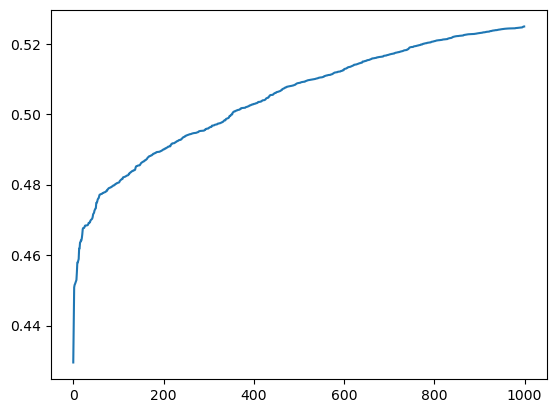

In [25]:
plt.figure()
plt.plot(prioritizations.p_sens.values[:1000])
plt.show()

In [245]:
prioritizations.groupby('indication').count()[['pert_iname']].sort_values(by='pert_iname', ascending=False).loc['melanoma']

pert_iname    12
Name: melanoma, dtype: int64

In [312]:
prioritizations.groupby('indication').count()[['pert_iname']].sort_values(by='pert_iname', ascending=False).loc['breast cancer']


pert_iname    36
Name: breast cancer, dtype: int64

In [267]:
prioritizations.groupby('indication').count()[['pert_iname']].sort_values(by='pert_iname', ascending=False)


,pert_iname
indication,
breast cancer,36
contraceptive,21
non-small cell lung cancer (NSCLC),18
melanoma,12
organ rejection|lymphangioleiomyomatosis,12
skin ulcer,12
menopause|vaginal atrophy|urinary tract infections,12
depression,9
renal cell carcinoma (RCC),9


In [116]:
# predicted p_viab 

with torch.no_grad(): 

    y_viab_dist = viab_ensemble(pred_expr_out2.cpu())

In [117]:
res2 = res.assign(viab_mean = y_viab_dist.mean.detach().cpu().numpy(), viab_var = y_viab_dist.variance.detach().cpu().numpy())
res2.head()

,cell_iname,pert_id,dose_um,viab_mean,viab_var
0,22RV1,BRD-A00147595,0.1,0.915585,0.023480
1,22RV1,BRD-A03249105,0.1,0.810121,0.062076
2,22RV1,BRD-A04706586,0.1,0.972585,0.011135
3,22RV1,BRD-A05680309,0.1,0.950167,0.020887
4,22RV1,BRD-A06304526,0.1,0.864421,0.042508


/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

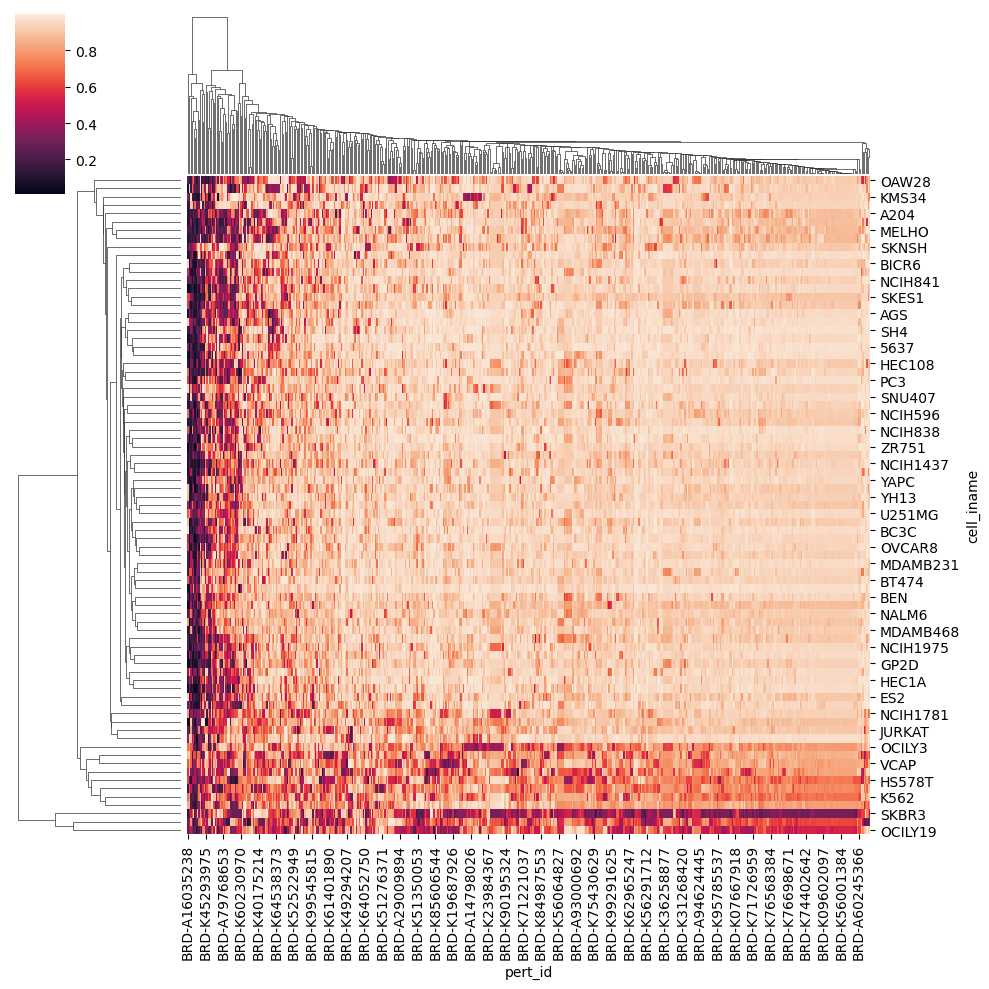

In [118]:
plt.figure()
sbn.clustermap(data=res2.pivot(index='cell_iname', columns='pert_id', values='viab_mean'), metric='euclidean')
plt.show()

In [37]:
# create "target dataset" 
# cell line, resp 

disease = 'skin cancer'

sens_lines = cellinfo[lambda x: x.primary_disease == disease].cell_iname.values.tolist()
res_lines = cellinfo[lambda x: x.primary_disease != disease].cell_iname.values.tolist() #[:len(sens_lines)]  # surrogates for normal tissue 

print('# sensitive lines:', len(sens_lines))
print('# resistant lines:', len(res_lines))

target_dataset = pd.DataFrame({'cell_iname':         sens_lines + res_lines,
                               'response':           [0.05]*len(sens_lines) + [0.95]*len(res_lines)})    # cell viability 


# define which drugs to search over
#                                                GSNN PERF          VIAB PERF (train)    VIAB PERF (test)
prioritization_drugspace = druginfo[['pert_id', 'cmap_name']].drop_duplicates().pert_id.values
print('# of drugs to search over:', len(prioritization_drugspace))

# convert "taget dataset" into a X,y 
X = get_base_X(cell_inames = target_dataset.cell_iname, proc='../output/exp1/proc/', data=data, instinfo=siginfo)
y = torch.FloatTensor(target_dataset.response.values)

cell_labels = np.array([1]*len(sens_lines) + [0]*len(res_lines)) # 1 if target-sensitive line 
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=cell_labels)
obs_weights = torch.tensor(class_weights[cell_labels])

print(X.size())
print(y.size())
# prioritize... 

print(sens_lines)
print(res_lines)

# sensitive lines: 7
# resistant lines: 72
# of drugs to search over: 506
torch.Size([79, 5374])
torch.Size([79])
['A375', 'SH4', 'SKMEL3', 'SKMEL5', 'IGR37', 'MELHO', 'CJM']
['22RV1', 'HEC1A', 'HL60', 'K562', 'THP1', 'MINO', 'SKES1', 'U2OS', 'A549', 'NCIH1437', 'NCIH1781', 'NCIH1975', 'NCIH2110', 'NCIH2172', 'NCIH596', 'NCIH838', 'NCIH841', 'LN229', 'HCT116', 'NCIH508', 'HEPG2', 'BT20', 'BT474', 'HS578T', 'MCF7', 'MDAMB231', 'MDAMB468', 'SKBR3', 'T47D', 'ZR751', 'G401', 'SKNSH', '5637', 'J82', 'AGS', 'ES2', 'PC3', 'VCAP', 'A204', 'TOV112D', 'JURKAT', 'NALM6', 'OCILY19', 'BEN', 'DV90', 'BC3C', 'CAL29', 'VMCUB1', 'YAPC', 'HCC95', 'SNU1040', 'SNU407', 'GP2D', 'COV434', 'OAW28', 'BICR6', 'KMS34', 'U251MG', 'YH13', 'HUH7', 'MKN45', 'OVTOKO', 'HEC108', 'HEC151', 'HEC251', 'HEC265', 'GI1', 'CW2', 'RCC10RGB', 'OVK18', 'OVCAR8', 'OCILY3']


In [38]:
class DrugPrioritization(torch.nn.Module): 
    '''
    Module for drug priortization. 

    Intended to be used in tandem with a target response dataset (x), e.g., a user-defined set of (cell lines, response) pairs that display a desired therapeutic behavior. 

    To induce sparsity in drug priortiziation, we allow the user to specify the order of drug combinations (1 indicates single agent prioritization), and we use the gumbel-softmax 
    function to ensure the constraint. 

    In 1d, this can be thought of as a categorical sampling operation over all drugs. 

    theta = [d1, d2, ..., dn] 
    samp  = [0,  1 , ..., 0 ]

    In 2d, this is again viewed as categorical sampling; however we perform this on a grid representing drug1 (rows) and drug2 (cols). 
    NOTE: we assume drug1,drug2 = drug2,drug1 and that drug1=/=drug2, therefore we only need to include the upper triangle during sampling (diagonal +1). 

    theta = 
        d1,  d2, ...,  dn
    d1  na  d1d2 ...  d1dn
    d2  na  na   ...  d2dn
    ... ... ...  ...  ...
    dn  na  na   ...   na

    drug1 ~ sum(theta, axis=0)
    drug2 ~ sum(theta, axis=1)

    This could be expanded to higher order combinations, but for now we will focus on only 1 (no comb) or 2 drugs combinations. 
        for 3-drug combinations or higher, this becomes less intuitive; however, the equivalent behavior can be achieved by summing over multiple dimensions. Assuming theta is a cube or hyper-cube, then:
        3-drug: drug1 = sum(theta, axis=[0,1]),   drug2 = sum(theta, axis=[1,2],    drug3 = sum(theta, axis[0,2]))
        4-drug: drug1 = sum(theta, axis=[0,1,2]), drug2 = sum(theta, axis=[0,1,3]), drug3 = sum(theta, axis=[0,2,3]), drug4 = sum(theta, axis=[1,2,3])
        etc... 


    To learn optimal drug concentrations, we also use a trainable scale parameter of the same shape as theta, such that drug_conc = gumbel_softmax(theta)*scale

    '''

    def __init__(self, model, drugspace, data, comb=False): 
        ''' 

        Args: 
            pred                cell viab model 
            drugspace           the prioritization drugspace, e.g., over which drugs should we search; NOTE: not the full GSNN drugspace
            data                the gsnn graph object 
            comb                bool                whether to search over all 2-drug combinations or single agents. 
        '''
        super().__init__()

        self.model = model

        self.comb= comb
        self.drugspace = drugspace 
        self.register_buffer('drug_idxs', torch.tensor(np.isin(data.node_names, np.array(['DRUG__' + x for x in drugspace])).nonzero()[0], dtype=torch.long))
        self.data = data 
        self.N = int(len(self.drug_idxs))

        if self.comb: 
            nparams = int((self.N**2 - self.N)/2)
            self.theta = torch.nn.Parameter(torch.zeros(nparams))
            self.scale = torch.nn.Parameter(torch.ones(nparams))
            self.dim = (self.N, self.N)
        else: 
            nparams = self.N
            self.theta = torch.nn.Parameter(torch.zeros(nparams))
            #self.scale = torch.nn.Parameter(torch.randn(nparams))
            self.scale = torch.nn.Parameter(.75*torch.ones(nparams))
            self.dim = (self.N)


    def forward(self, x, tau=1., hard=False): 
        ''' 
        x is assumed to have zero drug perturbations; e.g., all drug nodes are equal to zero
        '''
        
        # drug selection + dose 
        s = torch.nn.functional.gumbel_softmax(self.theta.view(1,-1), dim=-1, tau=tau, hard=hard)*self.scale.view(1,-1)

        if self.comb: 
            xc = torch.zeros(self.dim, device=x.device)
            r,c = torch.triu_indices(self.N, self.N, offset=1, device=x.device)
            xc[r, c] = s.squeeze()
            xc = xc.sum(dim=0) + xc.sum(dim=1)
            #print(xc)
        else: 
            xc = s

        out = torch.zeros_like(x) 
        out += x 
        out[:, self.drug_idxs] += xc.squeeze(0)

        # predict response 
        return self.model(out.unsqueeze(-1))

In [39]:
class GSNNViabNN(torch.nn.Module): 
    def __init__(self, gsnn, viab_nn, data, device='cuda'): 
        super().__init__()
        self.gsnn = gsnn.eval().to(device)
        self.viab_nn = viab_nn.eval().to(device)
        self.data = data.to(device)

    def forward(self, x): 

        out = self.gsnn(x)[:, data.output_node_mask]
        y = self.viab_nn(out)
        return y 

In [40]:

model = GSNNViabNN(gsnn, viab_ensemble, data).to('cuda')

In [50]:
prioritizer = DrugPrioritization(copy.deepcopy(model), prioritization_drugspace, data, comb=False).to('cuda').eval()
optim = torch.optim.Adam([prioritizer.theta, prioritizer.scale], lr=1e-2, weight_decay=0)
#crit = torch.nn.MSELoss(reduction='mean') 

#for i in range(len(prioritizer.model.viab_nn.models)):
#    prioritizer.model.viab_nn.models[i] = prioritizer.model.viab_nn.models[i].cuda()

X = X.to('cuda').clone().detach()
y = y.to('cuda').clone().detach()
X.requires_grad=False
y.requires_grad=False

obs_weights = obs_weights.to('cuda')

losses = []
rs = []
n = 1

for epoch in range(1000): 

    #for batch_idx in torch.randint(0, y.size(0), size=25):

    with torch.no_grad(): prioritizer.scale.clamp_(0.66, 1.167)

    optim.zero_grad() 
    yhat_dist = prioritizer(X, tau=3., hard=True)
    loss = -(yhat_dist.log_prob(y) * obs_weights).mean()
    loss.backward() 
    #torch.nn.utils.clip_grad_norm_([prioritizer.theta, prioritizer.scale], 3)
    optim.step() 
    losses.append(loss.detach().item())

    r = np.corrcoef(yhat_dist.mean.detach().cpu().numpy().ravel(), y.detach().cpu().numpy().ravel())[0,1]
    rs.append(r)

    print(f'epoch: {epoch} | running loss: {np.mean(losses[-n:]):.4f} | running r: {np.mean(rs[-n:]):.4f}', end='\r')


KeyboardInterrupt: 

In [469]:
# why does this yhat std get super small????
#       reinitializing prioritizer doesn't reset the yhat variance - what does this tell us? 
#       reinitializing X resets the variance ... why is X being modified and how? 
#       cloneing x in prioritizer fixes it but doesn't explain why  or what 

-0.08389488589257908


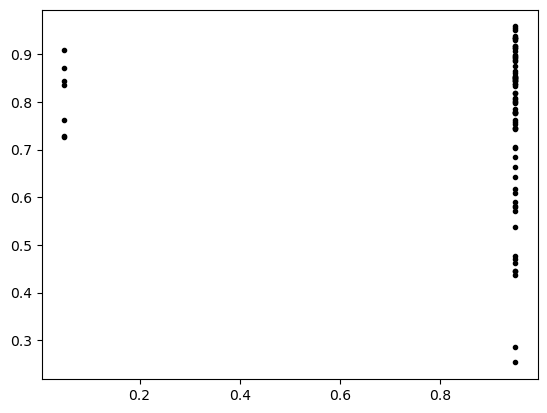

In [51]:
# TODO: plot the average pdf of sensitive lines vs resistant - e.g., instead of using means 

yhat = prioritizer.cuda()(X.cuda().detach(), tau=3, hard=True).mean
print(np.corrcoef(y.detach().cpu().numpy().ravel(), yhat.detach().cpu().numpy().ravel())[0,1])
plt.figure()
plt.plot(y.detach().cpu().numpy().ravel(), yhat.detach().cpu().numpy().ravel(), 'k.')
plt.show()

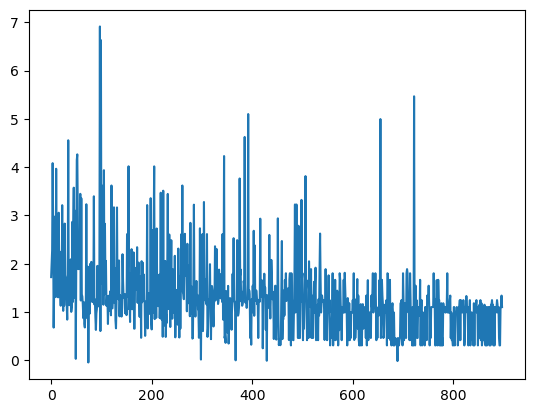

In [52]:
plt.figure()
plt.plot(losses)
plt.show()

In [53]:
10**(-np.array([1.]) * np.log10(1e-6)) - 1e-6

array([999999.999999])

In [63]:
dose2scale = lambda x: (np.log10(x + 1e-6) - np.log10(1e-6))/-np.log10(1e-6)
dose2scale(np.array([0.01]))

array([0.6666739])

In [55]:
scale2dose = lambda x: 10**(-np.log10(1e-6) * x + np.log10(1e-6)) - 1e-6 
scale2dose(np.array([1.35]))

array([125.89254018])

In [56]:
pd.DataFrame({'pert_id':[x.split('__')[1] for x in data.node_names[prioritizer.drug_idxs.cpu()]], 'prob':torch.softmax(prioritizer.theta, dim=-1).cpu().detach().numpy(), 'scale':prioritizer.scale.detach().cpu().numpy(), 'dose_um':scale2dose(prioritizer.scale.detach().cpu().numpy())}).merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), on='pert_id', how='left').sort_values('prob', ascending=False).head(15)

,pert_id,prob,scale,dose_um,cmap_name
110,BRD-K04210847,0.248948,1.178034,11.700499,tamoxifen
484,BRD-K94832621,0.186086,1.170202,10.500562,Y-134
424,BRD-K80431395,0.140991,1.172916,10.901806,triciribine
375,BRD-K68065987,0.124005,1.169032,10.332103,MK-2206
42,BRD-A42649439,0.097885,1.167211,10.075426,triciribine
20,BRD-A17828570,0.086291,1.174443,11.134112,fulvestrant
291,BRD-K48970916,0.039791,1.169218,10.358808,danazol
228,BRD-K29950728,0.028664,1.167098,10.059818,clomifene
95,BRD-K00312224,0.014547,1.172085,10.777295,PPT
142,BRD-K09499853,0.013490,0.660000,0.009119,KU-0060648


In [57]:
prioritization_drugspace

array(['BRD-K42805893', 'BRD-K62391742', 'BRD-K43002773', 'BRD-A50998626',
       'BRD-K39111395', 'BRD-K70301465', 'BRD-K45293975', 'BRD-K78373679',
       'BRD-K65503129', 'BRD-K68407802', 'BRD-K42828737', 'BRD-K84987553',
       'BRD-A12230535', 'BRD-K00317371', 'BRD-K64538373', 'BRD-K96778649',
       'BRD-K29313308', 'BRD-K76698671', 'BRD-K83837640', 'BRD-K04466929',
       'BRD-K12184916', 'BRD-K40175214', 'BRD-K68174511', 'BRD-K96084870',
       'BRD-K59204667', 'BRD-K30577245', 'BRD-K78659596', 'BRD-K54708045',
       'BRD-K09635314', 'BRD-A16694057', 'BRD-K00312224', 'BRD-A18497530',
       'BRD-K76568384', 'BRD-K62965247', 'BRD-A11007541', 'BRD-K09186807',
       'BRD-K03390685', 'BRD-A83237092', 'BRD-A03249105', 'BRD-A16035238',
       'BRD-K84925803', 'BRD-K11267252', 'BRD-K22149900', 'BRD-K78431006',
       'BRD-K32584078', 'BRD-K71480163', 'BRD-K25325018', 'BRD-A87137733',
       'BRD-K68065987', 'BRD-K80431395', 'BRD-A42649439', 'BRD-K56301217',
       'BRD-A38913120', '

In [349]:
druginfo[lambda x: x.pert_id.isin(prioritization_drugspace)].set_index('pert_id').loc['BRD-K99545815']

,cmap_name,compound_aliases,target,moa
pert_id,,,,
BRD-K99545815,PF-562271,NaN,PTK2B,Focal adhesion kinase inhibitor
BRD-K99545815,PF-562271,NaN,PTK2,Focal adhesion kinase inhibitor


In [133]:
model = model.cpu() 
X = X.cpu() 
yhat = model(X)
yhat

tensor([[0.1217],
        [0.1105],
        [0.0907],
        [0.2049],
        [0.1250],
        [0.0427],
        [0.0468],
        [0.0913],
        [0.0492],
        [0.0975],
        [0.0852]])

In [157]:
# select only the high performing perturbed expression genes 
best_inferred_genes_idx = np.isin(data.node_names[data.output_node_mask], np.array(['LINCS__' + x for x in best_inferred_genes])).nonzero()[0]

x_train2 = x_train[:, best_inferred_genes_idx]
x_test2 = x_test[:, best_inferred_genes_idx]
x_val2 = x_val[:, best_inferred_genes_idx]

# only use obs from drugs that we can predict well. 
#train_drugs = np.array([x.split('::')[1] for x in train_sigids])
#test_drugs = np.array([x.split('::')[1] for x in test_sigids])
#val_drugs = np.array([x.split('::')[1] for x in val_sigids])
#best_inferred_drugs_train_idxs = np.isin(train_drugs, best_inferred_drugs).nonzero()[0]
#best_inferred_drugs_test_idxs = np.isin(test_drugs, best_inferred_drugs).nonzero()[0]
#best_inferred_drugs_val_idxs = np.isin(val_drugs, best_inferred_drugs).nonzero()[0]

#x_train2 = x_train2[best_inferred_drugs_train_idxs]
#x_test2 = x_test2[best_inferred_drugs_test_idxs]
#x_val2 = x_val2[best_inferred_drugs_val_idxs]

#y_train2 = y_train[best_inferred_drugs_train_idxs]
#y_test2 = y_train[best_inferred_drugs_test_idxs]
#y_val2 = y_train[best_inferred_drugs_val_idxs]

mu = x_train2.mean(dim=0).unsqueeze(0)
sigma = x_train2.std(dim=0).unsqueeze(0)

x_train2 = (x_train2 - mu)/(sigma + 1e-12)
x_test2 = (x_test2 - mu)/(sigma + 1e-12)
x_val2 = (x_val2 - mu)/(sigma + 1e-12)

print(x_train2.size())
print(x_test2.size())
print(x_val2.size())

torch.Size([53547, 276])
torch.Size([12164, 276])
torch.Size([9261, 276])


In [171]:
pred = NN(in_channels=x_train2.shape[1], hidden_channels=100, layers=2, out_channels=1, dropout=0.2, nonlin=torch.nn.ELU, out=None, norm=True)
print(pred)
optim = torch.optim.Adam(pred.parameters(), lr=1e-3)#, weight_decay=1e-6) 
crit = torch.nn.MSELoss() 

batch_size = 1024

for epoch in range(1000): 

    for idx in torch.split(torch.arange(x_train2.size(0)), batch_size):
        optim.zero_grad()
        pred.train()
        yhat_train = pred(x_train2[idx]).squeeze()
        loss = crit(yhat_train, y_train[idx] )
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(pred.parameters(), 1, foreach=True)
        optim.step()

    pred.eval() 
    yhat_train = pred(x_train2).squeeze()
    r_train = np.corrcoef(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())[0,1]
    yhat_val = pred(x_val2).squeeze()
    r2_val = r2_score(y_val.detach().cpu().numpy(), yhat_val.detach().cpu().numpy())

    print(f'epoch: {epoch} | train r: {r_train:.2f} | val r2: {r2_val:.2f}', end='\r')

NN(
  (nn): Sequential(
    (0): Linear(in_features=276, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [172]:
pred.eval()

train_drugs = np.array([x.split('::')[1] for x in np.array(train_sigids)]) #)[best_inferred_drugs_train_idxs]])
test_drugs = np.array([x.split('::')[1] for x in np.array(test_sigids)]) #)[best_inferred_drugs_test_idxs]])
val_drugs = np.array([x.split('::')[1] for x in np.array(val_sigids)]) #)[best_inferred_drugs_val_idxs]])

drug_perf = {}
for drug in np.unique(train_drugs): 
    drug_idxs = (train_drugs == drug).nonzero()[0]
    _yhat = pred(x_train2[drug_idxs]).squeeze()
    _y = y_train[drug_idxs]
    drug_perf[drug] = r2_score(_y.detach().cpu().numpy(), _yhat.detach().cpu().numpy())

drug_perf = pd.DataFrame(drug_perf, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'r2_train'}, axis=1)

drug_perf2 = {}
for drug in np.unique(test_drugs): 
    drug_idxs = (test_drugs == drug).nonzero()[0]
    _yhat = pred(x_test2[drug_idxs]).squeeze()
    _y = y_test[drug_idxs]
    drug_perf2[drug] = r2_score(_y.detach().cpu().numpy(), _yhat.detach().cpu().numpy())

drug_perf2 = pd.DataFrame(drug_perf2, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'r2_test'}, axis=1)

drug_perf3 = {}
for drug in np.unique(val_drugs): 
    drug_idxs = (val_drugs == drug).nonzero()[0]
    _yhat = pred(x_val2[drug_idxs]).squeeze()
    _y = y_val[drug_idxs]
    drug_perf3[drug] = r2_score(_y.detach().cpu().numpy(), _yhat.detach().cpu().numpy())

drug_perf3 = pd.DataFrame(drug_perf3, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'r2_val'}, axis=1)

drug_perf = drug_perf.merge(drug_perf2, on='pert_id', how='left').merge(drug_perf3, on='pert_id', how='left').sort_values(by='r2_test', ascending=False)
drug_perf.head(10)

,pert_id,r2_train,r2_test,r2_val
208,BRD-K99545815,0.819552,0.663323,-0.959692
40,BRD-K11636097,0.726780,0.661525,0.483036
47,BRD-K13390322,0.648040,0.601067,0.275154
49,BRD-K13662825,0.714756,0.600811,0.306043
104,BRD-K44227013,0.713601,0.598081,0.031936
80,BRD-K28360340,0.841908,0.573355,0.215453
102,BRD-K43578482,0.746162,0.554475,-4.975723
61,BRD-K17743125,0.653440,0.544809,-0.858118
189,BRD-K88510285,0.756748,0.529985,0.415759
45,BRD-K12867552,0.900261,0.510256,0.272955


In [173]:
drug_perf.corr()

/tmp/ipykernel_25269/197720671.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  drug_perf.corr()


,r2_train,r2_test,r2_val
r2_train,1.000000,0.667471,0.191716
r2_test,0.667471,1.000000,0.381529
r2_val,0.191716,0.381529,1.000000


0.3512931120688765


/tmp/ipykernel_25269/1924002334.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr().values[0,1])


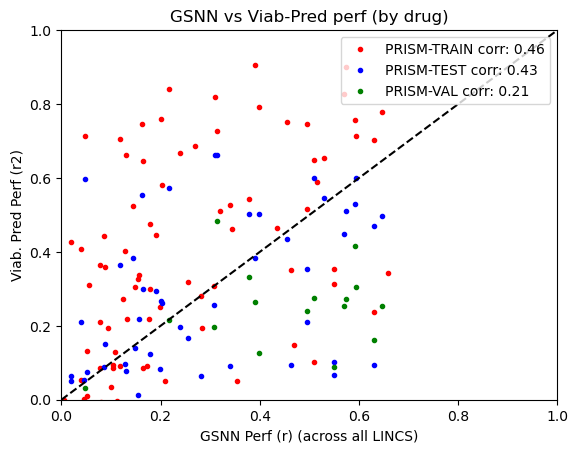

In [174]:
df = r_drug.merge(drug_perf, on='pert_id', how='left')
print(df.corr().values[0,1])
plt.figure()
plt.plot(df.r, df.r2_train, 'r.', label=f'PRISM-TRAIN corr: {df[lambda x: (x.r > 0) & (x.r2_train > 0)][["r", "r2_train"]].corr(method="spearman").values[0,1]:.2f}')
plt.plot(df.r, df.r2_test, 'b.', label=f'PRISM-TEST corr: {df[lambda x: (x.r > 0) & (x.r2_test > 0)][["r", "r2_test"]].corr(method="spearman").values[0,1]:.2f}')
plt.plot(df.r, df.r2_val, 'g.', label=f'PRISM-VAL corr: {df[lambda x: (x.r > 0) & (x.r2_val > 0)][["r", "r2_val"]].corr(method="spearman").values[0,1]:.2f}')

plt.xlim(0,1)
plt.ylim(0,1)
plt.plot((0,1), (0,1), 'k--')
plt.xlabel('GSNN Perf (r) (across all LINCS)')
plt.ylabel('Viab. Pred Perf (r2)')
plt.title('GSNN vs Viab-Pred perf (by drug)')
plt.legend()
plt.show()

r test 0.5306675164596687
r2 0.26490227922761456


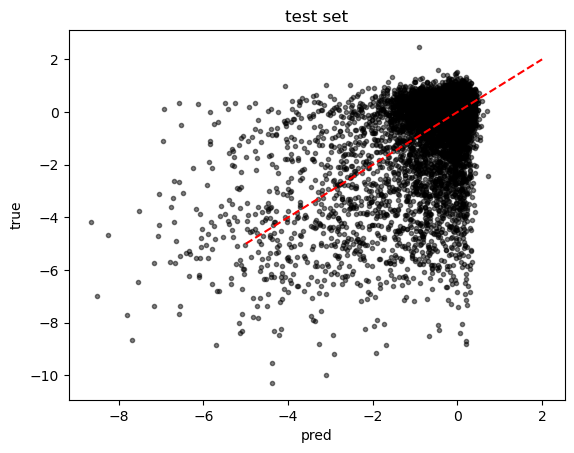

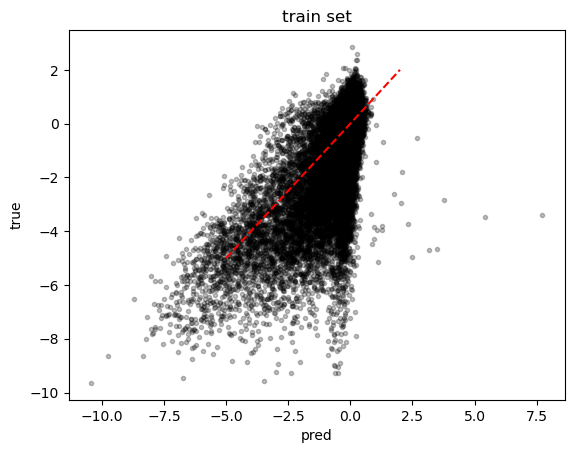

In [166]:
pred.eval()
yhat_test = pred(x_test2).squeeze()
yhat_train = pred(x_train2).squeeze()
r_test = np.corrcoef(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())[0,1]
print('r test', r_test)
print('r2', r2_score(y_test.detach().cpu().numpy().ravel(), yhat_test.detach().cpu().numpy().ravel()))

plt.figure()
plt.xlabel('pred'); plt.ylabel('true')
plt.title('test set')
plt.plot(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), 'k.', alpha=0.5)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

plt.figure()
plt.title('train set')
plt.xlabel('pred'); plt.ylabel('true')
plt.plot(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy(), 'k.', alpha=0.25)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

In [ ]:
t = -2 

y_train2 = (y_train < t)*1.
y_test2 = (y_test < t)*1.
y_val2 = (y_val < t)*1.

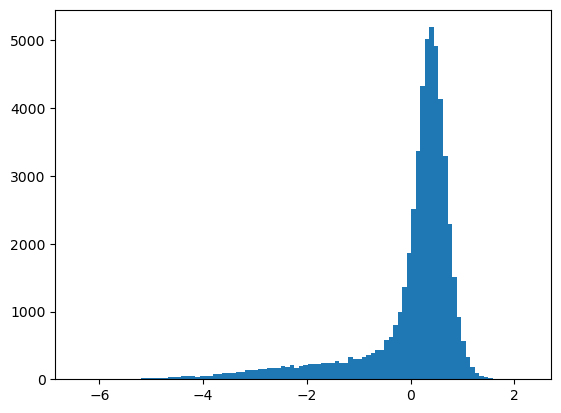

In [ ]:
plt.figure()
plt.hist(y_train, bins=100)
plt.show()

In [ ]:
train_sigids[0]

'MCF7::BRD-A00147595::2.5'

In [ ]:
# should add a step here to select output genes that are well predicted - particularly for explaining cell-cell variance. 
# e.g., best_inferred = A,B,C 
#       x_best_inferred = x[:, best_inferred]
# 

In [ ]:
def train_pred(y_train, y_val, y_test, p=0.5): 

    pred = NN(in_channels=x_train.shape[1], hidden_channels=10, layers=2, out_channels=1, dropout=0.2, nonlin=torch.nn.ELU, out=torch.nn.Sigmoid)
    optim = torch.optim.Adam(pred.parameters(), lr=1e-4) 
    #crit = torch.nn.MSELoss() 
    crit = torch.nn.BCELoss() 

    idx = torch.randperm(y_train.size(0))[:int(y_train.size(0)*p)]

    for epoch in range(100): 

        optim.zero_grad()
        pred.train()
        yhat_train = pred(x_train[idx, :]).squeeze()
        loss = crit(yhat_train, y_train[idx] )
        loss.backward()
        optim.step()

        pred.eval() 
        yhat_train = pred(x_train).squeeze()
        r_train = np.corrcoef(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())[0,1]
        yhat_val = pred(x_val).squeeze()
        r_val = np.corrcoef(yhat_val.detach().cpu().numpy(), y_val.detach().cpu().numpy())[0,1]

        print(f'epoch: {epoch} | train r: {r_train:.2f} | val r: {r_val:.2f}', end='\r')

    yhat_test = pred(x_test).squeeze()
    r_test = np.corrcoef(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())[0,1]
    print('r test', r_test)

    return pred 

In [ ]:
ensemble = [] 
for i in range(10): 
    ensemble.append(train_pred(y_train, y_val, y_test)) 

r test 0.4996468302658726 | val r: 0.351
r test 0.5205260216556973 | val r: 0.34
r test 0.4866140985365912 | val r: 0.34
r test 0.49584426865559184| val r: 0.33
r test 0.4779650669494907 | val r: 0.33
r test 0.4544695056914315 | val r: 0.33
r test 0.5290372548375083 | val r: 0.34
r test 0.4878345394897076 | val r: 0.34
r test 0.5077854188834091 | val r: 0.39
r test 0.5369227425353195 | val r: 0.35


In [ ]:
yhat_test = [] 
for m in ensemble: 
    yhat_test.append(m(x_test).squeeze())

yhat_test = torch.stack(yhat_test, dim=1)
yhat_test.size()

torch.Size([12164, 10])

In [ ]:
np.corrcoef(y_test.detach().cpu().numpy(), yhat_test.mean(dim=1).detach().cpu().numpy())[0,1]

0.5064075565745948

In [ ]:
for epoch in range(1000): 

    optim.zero_grad()
    pred.train()
    yhat_train = pred(x_train).squeeze()
    loss = crit(yhat_train, y_train )
    loss.backward()
    optim.step()

    pred.eval() 
    yhat_train = pred(x_train).squeeze()
    r_train = np.corrcoef(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())[0,1]
    yhat_val = pred(x_val).squeeze()
    r_val = np.corrcoef(yhat_val.detach().cpu().numpy(), y_val.detach().cpu().numpy())[0,1]

    print(f'epoch: {epoch} | train r: {r_train:.2f} | val r: {r_val:.2f}', end='\r')



In [ ]:
yhat_test = pred(x_test).squeeze()
r_test = np.corrcoef(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())[0,1]
r_test

-0.48673186988203615

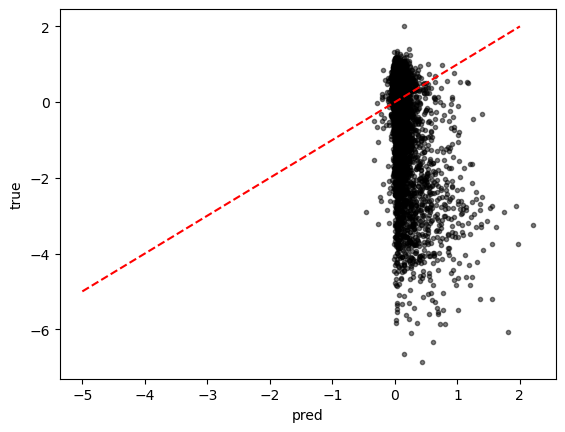

In [ ]:
plt.figure()
plt.xlabel('pred'); plt.ylabel('true')
plt.plot(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), 'k.', alpha=0.5)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

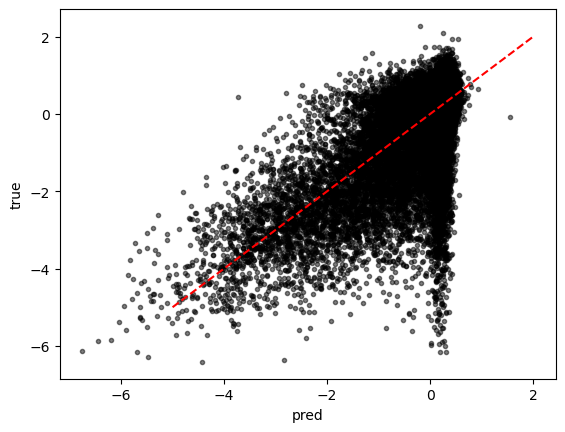

In [ ]:
plt.figure()
plt.xlabel('pred'); plt.ylabel('true')
plt.plot(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy(), 'k.', alpha=0.5)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

In [ ]:
class GSNN2VIAB(torch.nn.Module): 
    '''
    frozen GSNN -> viab model 

    out = f_viab(f_gsnn(x))
    ''' 
    
    def __init__(self, model, pred, out_mask=None): 
        '''

        Args: 
            model       torch.Module            trained GSNN model 
            pred        torch.Module            trained cell viab model 
            out_mask    torch.tensor            boolean tensor specifying which outputs are used as input to cell viab model 
        '''
        super().__init__()

        self.model = model
        self.model.training = False 
        for p in self.model.parameters(): p.requires_grad = False

        self.pred = pred 
        self.pred.training = False 
        for p in self.pred.parameters(): p.requires_grad = False

        self.out_mask = out_mask 

    def forward(self, x): 

        out = self.model(x)
        if self.out_mask is not None: out = out[self.out_mask]

        out = self.pred(out) 

        return out 
    

    




In [ ]:
class DrugPrioritization(torch.nn.Module): 
    '''
    Module for drug priortization. 

    Intended to be used in tandem with a target response dataset (x), e.g., a user-defined set of (cell lines, response) pairs that display a desired therapeutic behavior. 

    To induce sparsity in drug priortiziation, we allow the user to specify the order of drug combinations (1 indicates single agent prioritization), and we use the gumbel-softmax 
    function to ensure the constraint. 

    In 1d, this can be thought of as a categorical sampling operation over all drugs. 

    theta = [d1, d2, ..., dn] 
    samp  = [0,  1 , ..., 0 ]

    In 2d, this is again viewed as categorical sampling; however we perform this on a grid representing drug1 (rows) and drug2 (cols). 
    NOTE: we assume drug1,drug2 = drug2,drug1 and that drug1=/=drug2, therefore we only need to include the upper triangle during sampling (diagonal +1). 

    theta = 
        d1,  d2, ...,  dn
    d1  na  d1d2 ...  d1dn
    d2  na  na   ...  d2dn
    ... ... ...  ...  ...
    dn  na  na   ...   na

    drug1 ~ sum(theta, axis=0)
    drug2 ~ sum(theta, axis=1)

    This could be expanded to higher order combinations, but for now we will focus on only 1 (no comb) or 2 drugs combinations. 
        for 3-drug combinations or higher, this becomes less intuitive; however, the equivalent behavior can be achieved by summing over multiple dimensions. Assuming theta is a cube or hyper-cube, then:
        3-drug: drug1 = sum(theta, axis=[0,1]),   drug2 = sum(theta, axis=[1,2],    drug3 = sum(theta, axis[0,2]))
        4-drug: drug1 = sum(theta, axis=[0,1,2]), drug2 = sum(theta, axis=[0,1,3]), drug3 = sum(theta, axis=[0,2,3]), drug4 = sum(theta, axis=[1,2,3])
        etc... 


    To learn optimal drug concentrations, we also use a trainable scale parameter of the same shape as theta, such that drug_conc = gumbel_softmax(theta)*scale

    '''

    def __init__(self, model, drug_mask, comb=False): 
        ''' 

        Args: 
            pred                cell viab model 
            drug_mask           tensor              boolean mask for which drugs should be included in the priortiziation search; drugs with a false label will be assigned a value of zero for the search.  
            comb                bool                whether to search over all 2-drug combinations or single agents. 
        '''
        super().__init__()

        self.model = model

        self.comb= comb
        self.drug_mask = drug_mask
        self.N = int(drug_mask.sum())

        if self.comb: 
            nparams = int((self.N**2 - self.N)/2)
            self.theta = torch.nn.Parameter(torch.zeros(nparams))
            self.scale = torch.nn.Parameter(torch.ones(nparams))
            self.dim = (self.N, self.N)
        else: 
            nparams = self.N
            self.theta = torch.nn.Parameter(torch.zeros(nparams))
            self.scale = torch.nn.Parameter(torch.ones(nparams))
            self.dim = (self.N)


    def forward(self, x, tau=1.): 
        ''' 
        x is assumed to have zero drug perturbations; e.g., all drug nodes are equal to zero
        '''
        # sample drug combination 
        s = torch.nn.functional.gumbel_softmax(self.theta.view(-1,1), tau=tau, hard=False)*self.scale.view(-1,1) 
        d = torch.zeros(self.dim, device=x.device)
        if self.comb: 
            d[torch.triu_indices(self.N, self.N, offset=1)] += s
        else: 
            d += s

        xc = torch.zeros_like(x)
        for i in range(len(d.size())): xc[self.drug_mask] += d.sum(dim=i) 

        # add the sampled drug perturbation
        x += xc

        # predict response 
        return self.model(x)

In [ ]:
prism = utils.load_prism('../../data/', cellspace=data.cellspace, drugspace=data.drugspace)

In [ ]:
prism.head()

,pert_id,depmap_id,cell_iname,pert_dose,log_fold_change,screen_id,num_repl,sig_id,cell_viab
0,BRD-K07106112,ACH-000019,MCF7,0.000610,0.292371,[secondary],1,MCF7::BRD-K07106112::0.00061034,1.224651
1,BRD-K07106112,ACH-000019,MCF7,0.002441,0.420013,[secondary],1,MCF7::BRD-K07106112::0.0024414,1.337940
2,BRD-K07106112,ACH-000019,MCF7,0.009766,-0.038470,[secondary],1,MCF7::BRD-K07106112::0.00976562,0.973687
3,BRD-K07106112,ACH-000019,MCF7,0.039062,0.678407,[secondary],1,MCF7::BRD-K07106112::0.0390625,1.600372
4,BRD-K07106112,ACH-000019,MCF7,0.156250,0.021690,[secondary],1,MCF7::BRD-K07106112::0.15625,1.015148


In [ ]:
data

Data(node_names=[814], edge_index=[2, 1222], input_edge_mask=[1222], output_edge_mask=[1222], input_node_ixs=[560], output_node_ixs=[100], input_node_mask=[814], output_node_mask=[814], cellspace=[75], drugspace=[74])

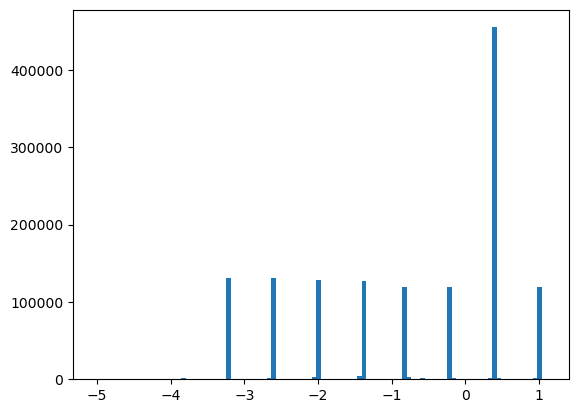

In [ ]:
plt.figure()
plt.hist(np.log10(prism.pert_dose.values), bins=100)
plt.show()

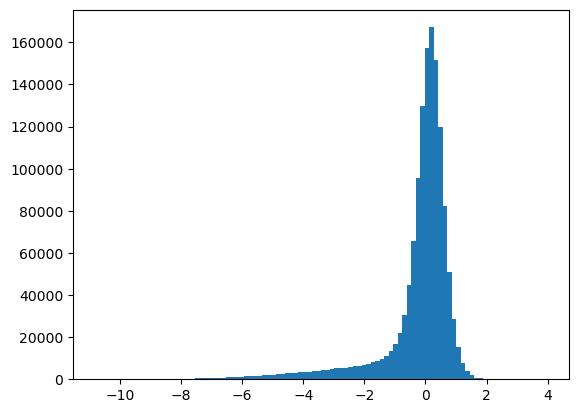

In [ ]:
plt.figure()
plt.hist(prism.log_fold_change, bins=100)
plt.show()